# Analysis of GeoDanmark at the municipal level

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
import h3

from src import evaluation_functions as eval_func

%run ../settings/yaml_variables.py
%run ../settings/df_styler.py
%run ../settings/plotting.py
%run ../settings/load_refdata.py
%run ../settings/paths.py

/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
<string>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/Users/anev/Library/CloudStorage/Dropbox/ITU/repositories/bikedna_dk_analysis/settings/plotting.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases 

Reference data loaded successfully!


In [2]:
# Read intrinsic grid results
with open(
    f"../results/reference/{study_area}/data/grid_results_intrinsic.pickle", "rb"
) as fp:
    ref_intrinsic_grid = pickle.load(fp)

# Import intrinsic results
ref_intrinsic_file = open(
    f"../results/reference/{study_area}/data/intrinsic_analysis.json"
)

ref_intrinsic_results = json.load(ref_intrinsic_file)

# Import summary dataframe
summarize_results_df = pd.read_csv(f"../results/reference/{study_area}/data/intrinsic_summary_results.csv",index_col=0)

summarize_results_df.style.pipe(format_ref_style)

,
Total infrastructure length (km),"8,676"
Protected bicycle infrastructure density (m/km2),92
Unprotected bicycle infrastructure density (m/km2),95
Mixed protection bicycle infrastructure density (m/km2),0
Bicycle infrastructure density (m/km2),187
Nodes,"51,224"
Dangling nodes,"11,218"
Nodes per km2,1
Dangling nodes per km2,0
Overshoots,99


## Municipal Analysis

In [3]:
# Read muni data
muni = gpd.read_file(muni_polygons_fp)
muni = muni[['navn','kommunekode','geometry']]
assert muni.crs == study_crs

**Assign municipal ID/name to all grid cells**

In [4]:
# Assign municipal name and id to each hex cell based on centroid overlap
ref_intrinsic_grid.dropna(subset='count_ref_edges',inplace=True)

grid_centroids = ref_intrinsic_grid[['geometry','grid_id','count_ref_edges']].copy()
grid_centroids['geometry'] = grid_centroids.geometry.centroid

joined_int_grid = eval_func.index_by_muni(grid_centroids, muni)

int_grid = ref_intrinsic_grid.merge(joined_int_grid[['grid_id','navn','kommunekode']],left_on='grid_id',right_on='grid_id')
assert len(int_grid) == len(ref_intrinsic_grid)

**Index nodes and edges by municipality**

In [5]:
# Index nodes and edges by municipality
muni_edges = eval_func.index_by_muni(ref_edges_simplified, muni, assert_len=False)

muni_nodes = eval_func.index_by_muni(ref_nodes_simplified, muni, assert_len=True, drop_dupli=True, dupli_id='nodeID')
assert len(muni_nodes) == len(muni_nodes.nodeID.unique())

# Recompute length - for GeoDK, infra length is equal to geom length
muni_edges['infrastructure_length'] = muni_edges.geometry.length

# Index dangling nodes by muni
muni_dang = eval_func.index_by_muni(ref_dangling, muni, assert_len=True, drop_dupli=True, dupli_id='nodeID')
assert len(muni_dang) == len(muni_dang.nodeID.unique())

# Group by muni
grouped_edges = muni_edges.groupby("navn") 
grouped_nodes = muni_nodes.groupby("navn")
grouped_dangling = muni_dang.groupby("navn")

# Turn into dataframe
muni_infra = grouped_edges['infrastructure_length'].sum().to_frame()

muni_node_count = grouped_nodes.size().to_frame('node_count') 

muni_dang_count = grouped_dangling.size().to_frame('dangling_node_count') 

muni_network_counts = pd.merge(pd.merge(muni_infra, muni_node_count,left_index=True, right_index=True),muni_dang_count,left_index=True, right_index=True)

assert len(muni_network_counts) == 98


**Plot length of bicycle infrastructure, bicycle infrastructure density and infrastructure per 1000 people**

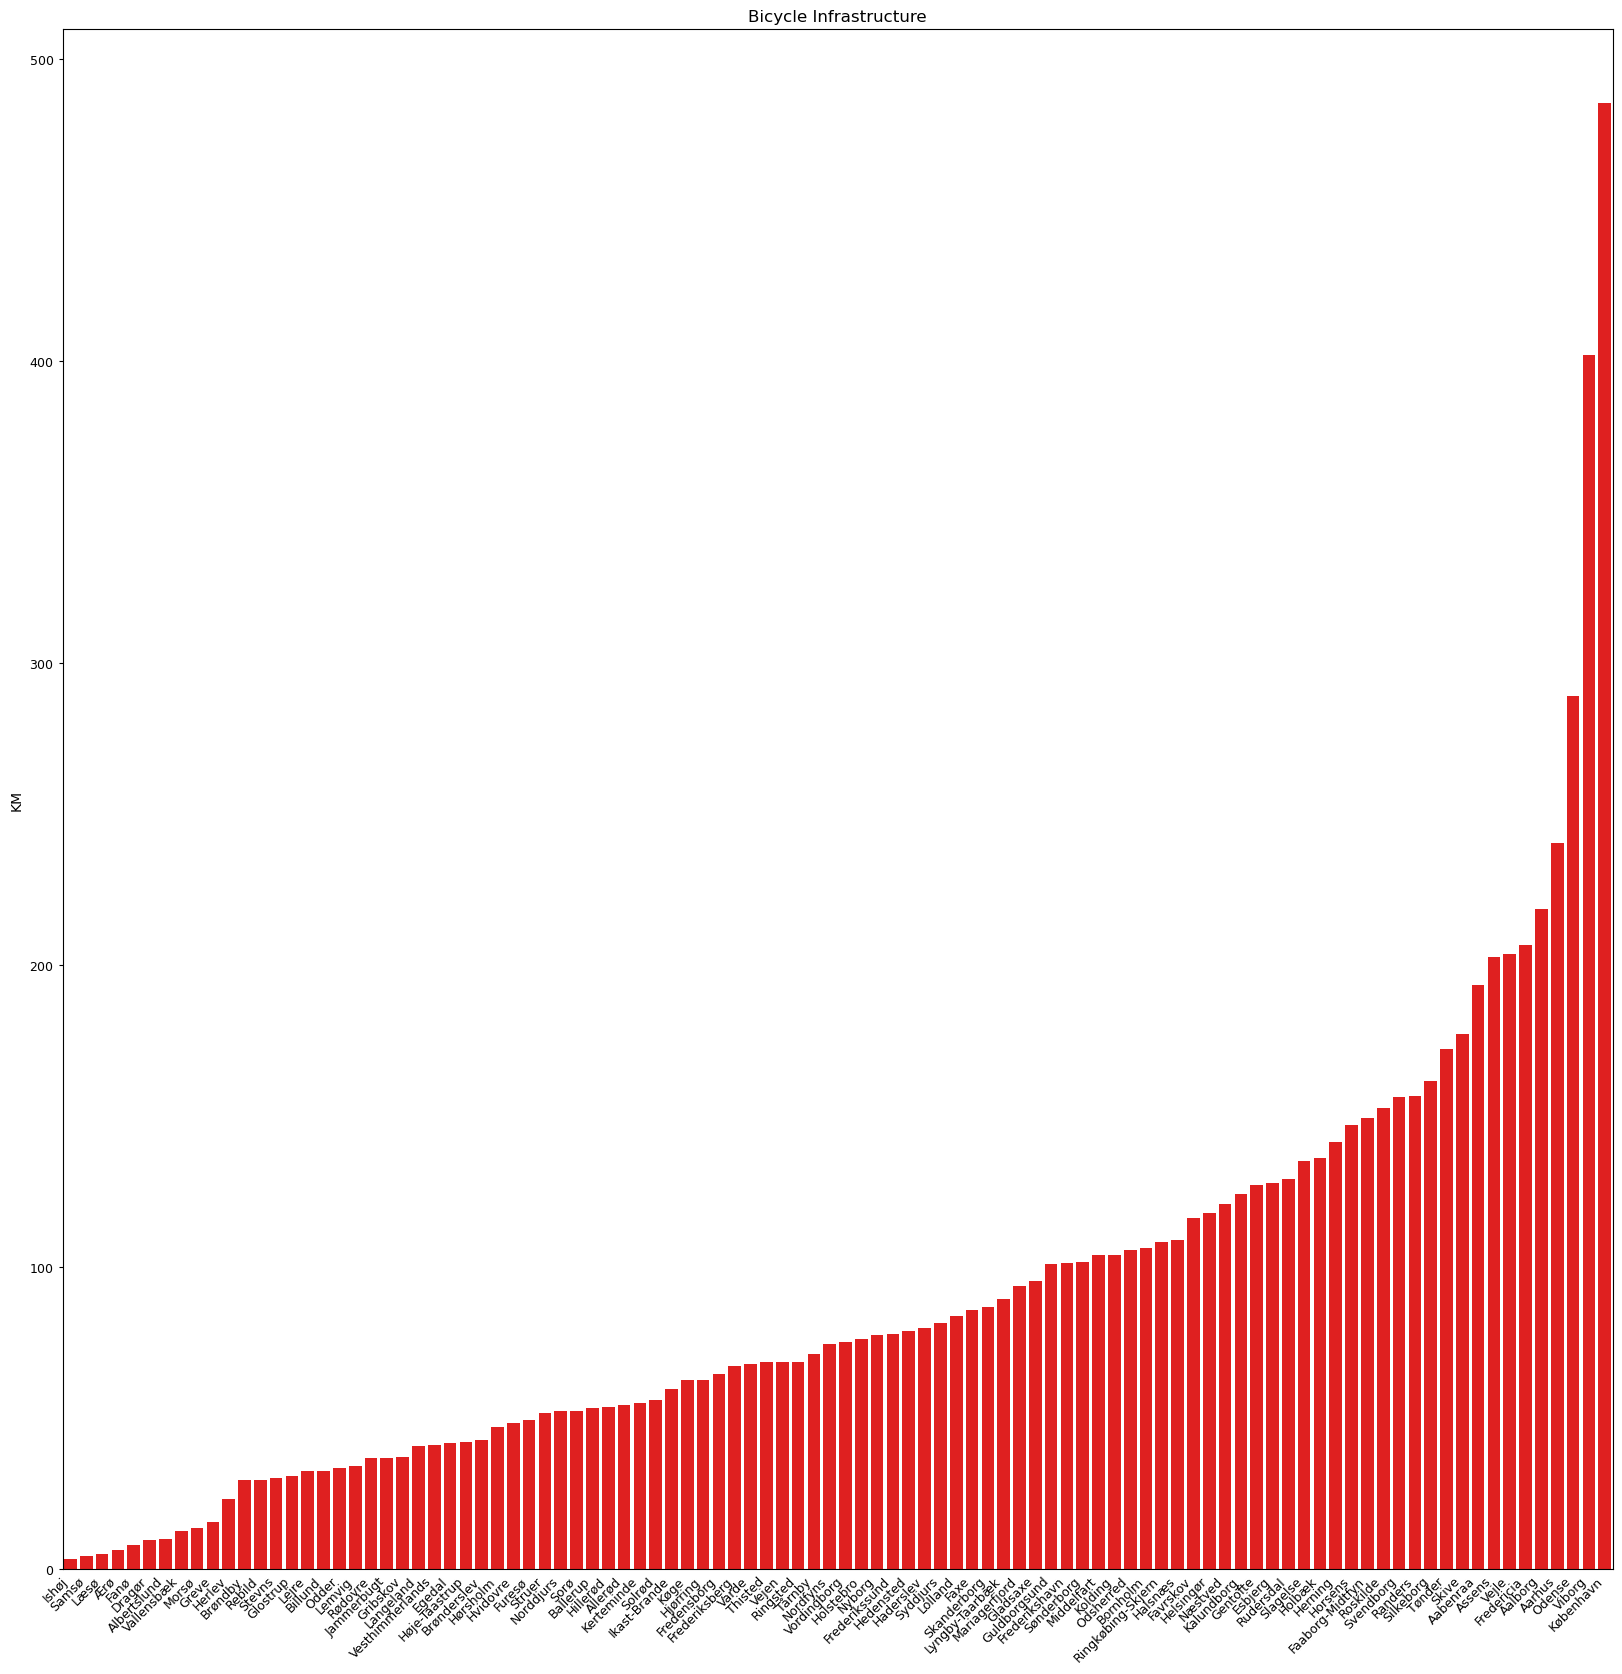

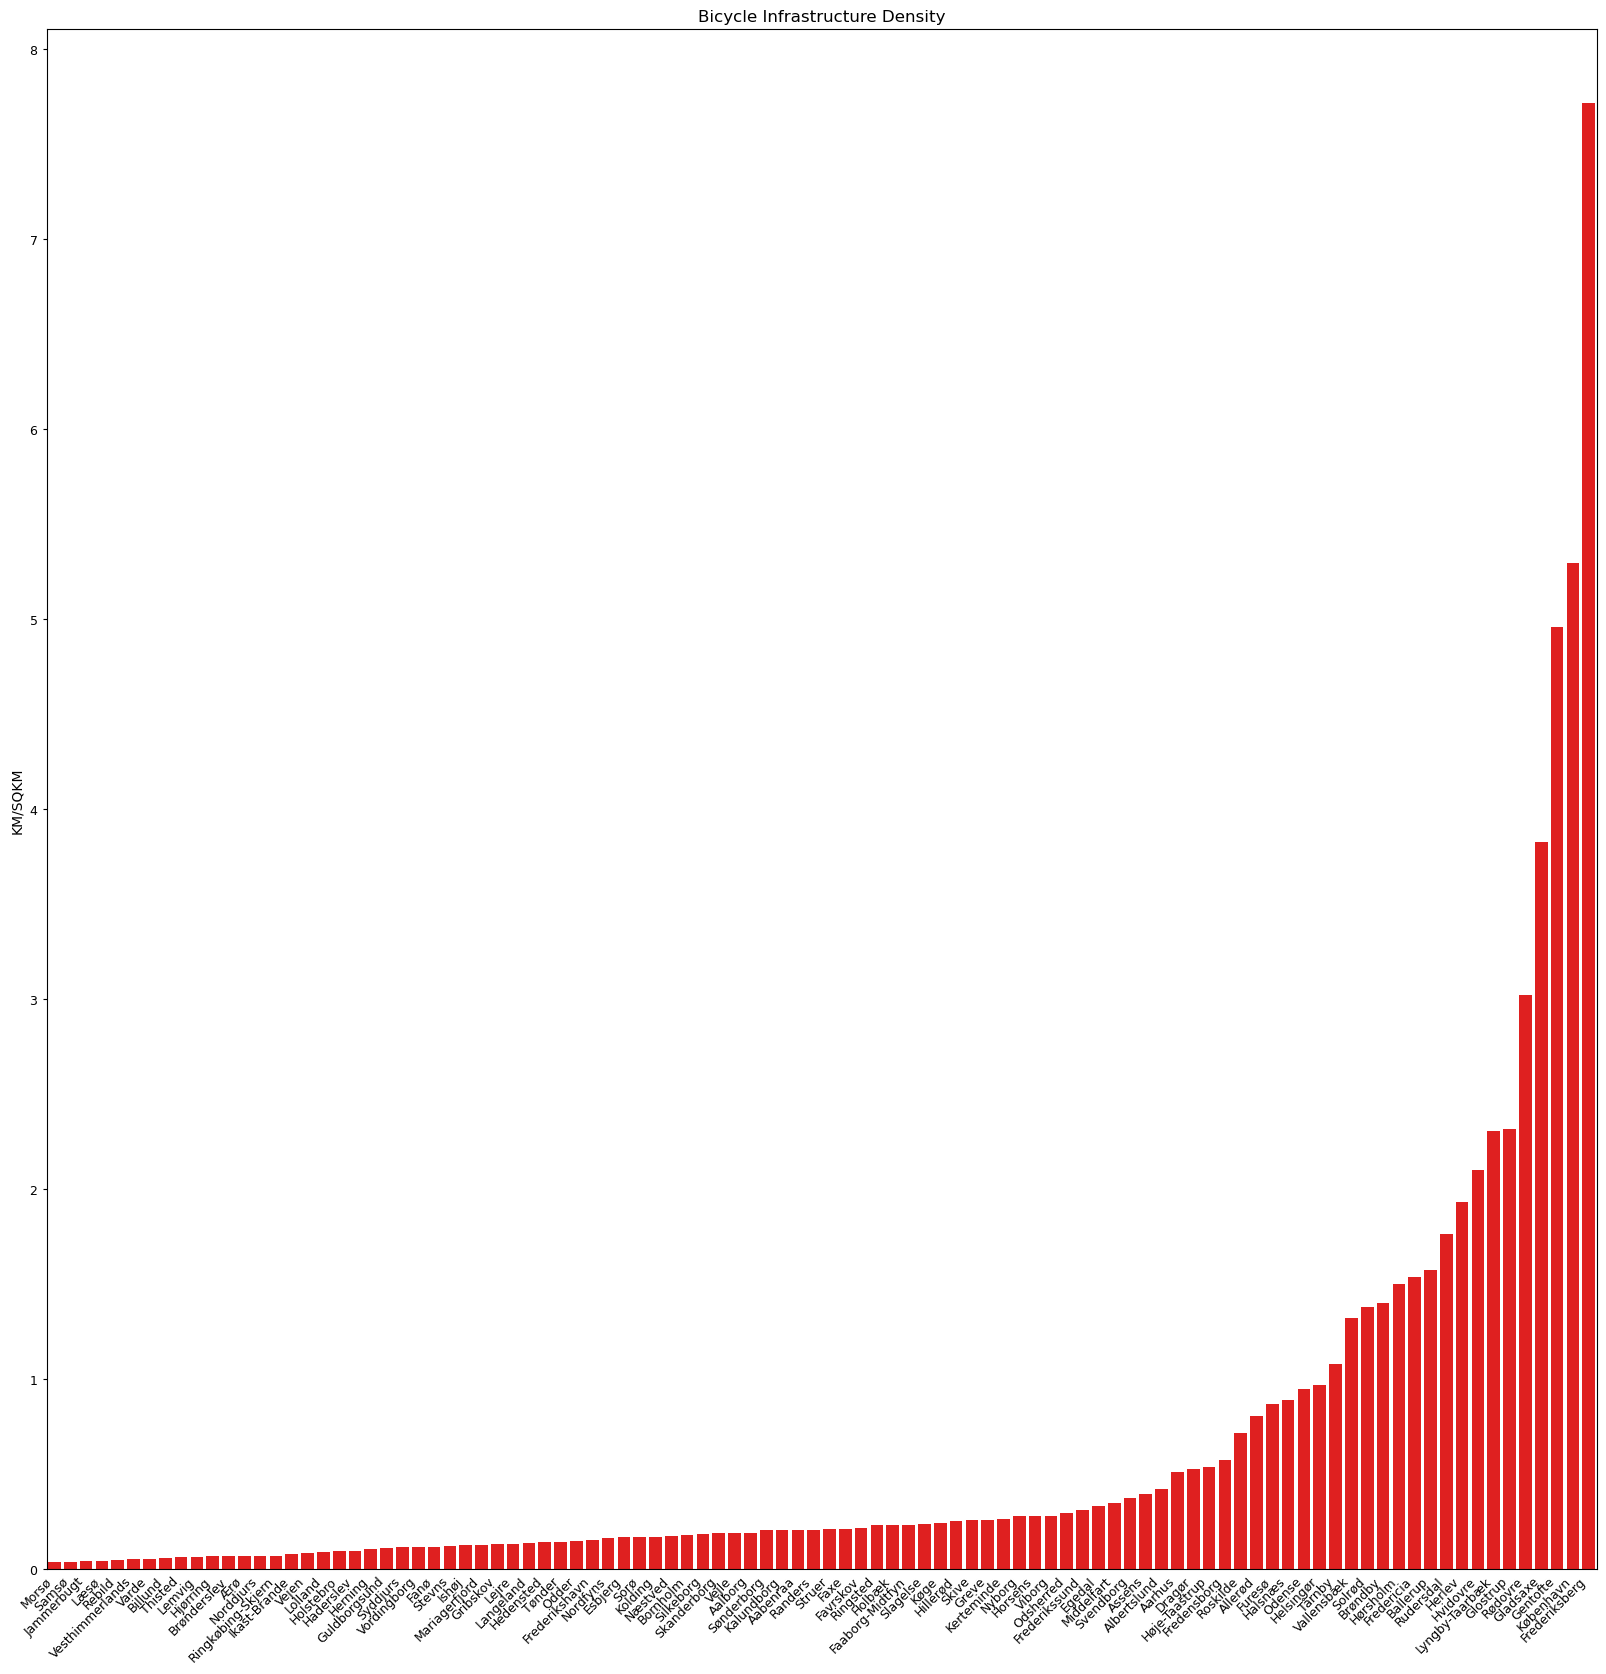

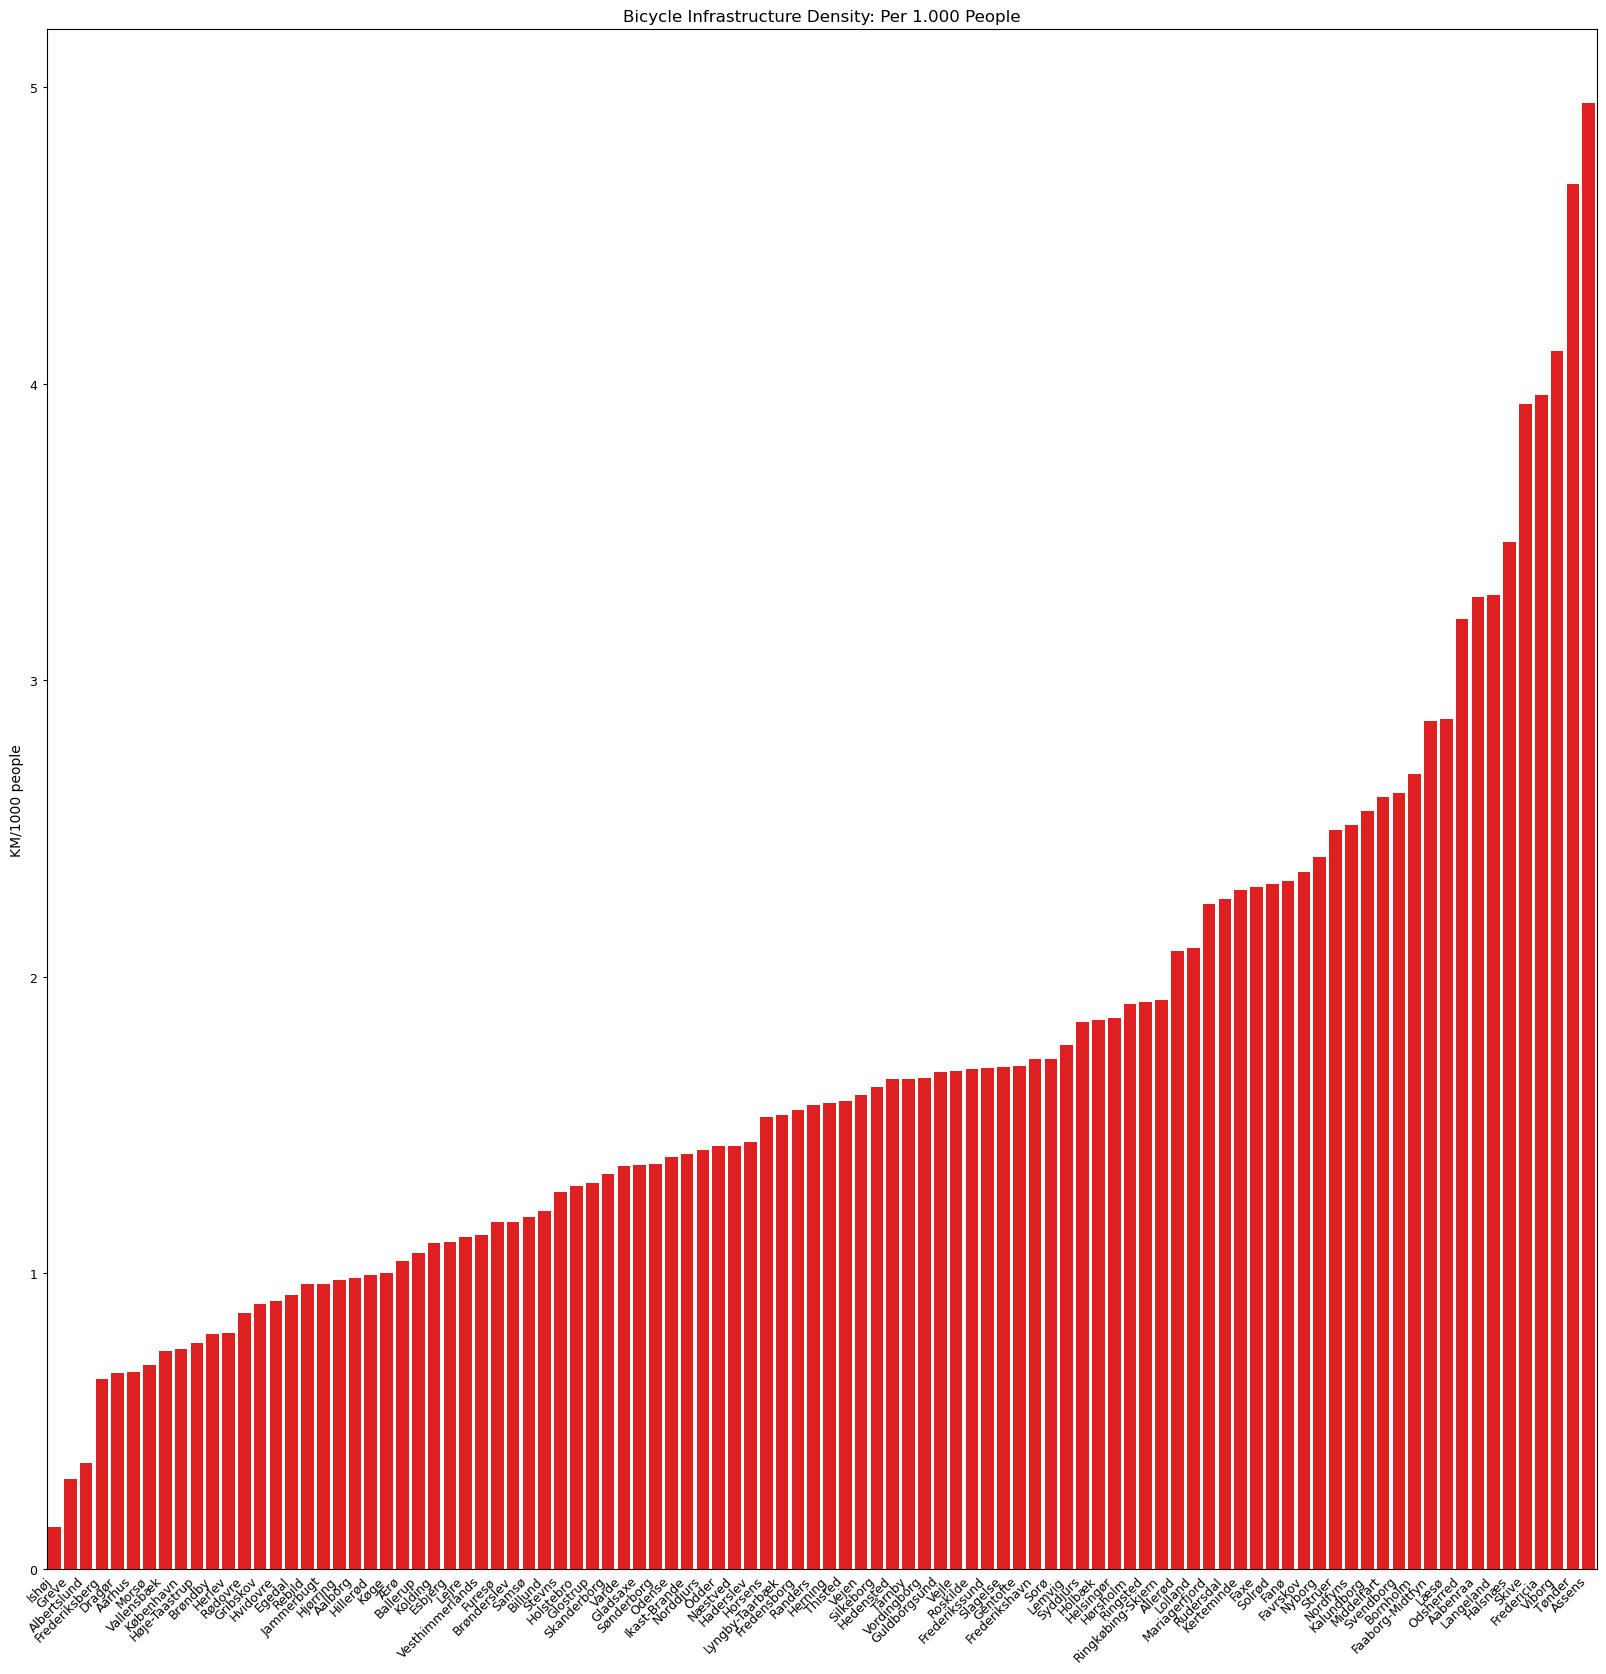

In [6]:
# Plot km of bicycle infra per muni
muni_network_counts["infra_km"] = round(
    muni_network_counts.infrastructure_length / 1000, 3
)

fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(
    muni_network_counts.reset_index().sort_values("infra_km"),
    x="navn",
    y="infra_km",
    ax=ax,
    color="red",
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("KM")
plt.title("Bicycle Infrastructure")

# Plot infra density per muni
muni["area_sqkm"] = round(muni.area / 1000000, 2)

muni_network_counts = muni_network_counts.merge(
    muni[["navn", "area_sqkm"]], left_index=True, right_on="navn"
)

muni_network_counts["infra_dens"] = round(
    muni_network_counts.infra_km / muni_network_counts.area_sqkm, 3
)

fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(
    muni_network_counts.reset_index().sort_values("infra_dens"),
    x="navn",
    y="infra_dens",
    ax=ax,
    color="red",
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("KM/SQKM")
plt.title("Bicycle Infrastructure Density")

# Plot infra per pop
muni_pop = pd.read_csv(muni_pop_fp, encoding="ISO-8859-1", header=None)
muni_pop.rename({1: "navn", 2: "pop"}, inplace=True, axis=1)

muni_network_counts = muni_network_counts.merge(
    muni_pop[["navn", "pop"]], left_on="navn", right_on="navn"
)
assert len(muni_network_counts) == 98

muni_network_counts["infra_pop"] = muni_network_counts.infra_km / (
    muni_network_counts["pop"] / 1000
)

fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(
    muni_network_counts.reset_index().sort_values("infra_pop"),
    x="navn",
    y="infra_pop",
    ax=ax,
    color="red",
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("KM/1000 people")
plt.title("Bicycle Infrastructure Density: Per 1.000 People");


**Index over and undershoots by municipality**

In [7]:
# Join over and undershoot to muni
overshoot_edge_ids = pd.read_csv(ref_results_data_fp+"overshoot_edges_3.csv")
undershoot_node_ids = pd.read_csv(ref_results_data_fp+"undershoot_nodes_3.csv")

undershoots = ref_nodes_simplified[ref_nodes_simplified.nodeID.isin(undershoot_node_ids.node_id)]
assert len(undershoot_node_ids) == len(undershoots)

overshoots = ref_edges_simplified[ref_edges_simplified.edge_id.isin(overshoot_edge_ids.edge_id)]
assert len(overshoot_edge_ids) == len(overshoots)

# Join to muni
over_muni = overshoots[['edge_id','geometry']].sjoin(muni,how='left',predicate='intersects')

under_muni = undershoots[['nodeID','geometry']].sjoin(muni,how='left', predicate='intersects')

assert len(over_muni) == len(overshoots)
assert len(under_muni) == len(undershoots)

# Group by muni and count
over_df = over_muni.groupby('navn').size().to_frame('overshoots')

under_df = under_muni.groupby('navn').size().to_frame('undershoots')

# Combine with muni_network
muni_network_counts = pd.merge(muni_network_counts, over_df,left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98

muni_network_counts = pd.merge(muni_network_counts, under_df,left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98

muni_network_counts['over_under'] = muni_network_counts.overshoots + muni_network_counts.undershoots
muni_network_counts['over_under'].fillna(0,inplace=True)

**Join over and undershoots to grid cells**

In [8]:
# Join over and undershoots to grid ids
overshoots_grid = overshoots[['edge_id','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='edge_id',keep="first")[['grid_id']].reset_index(drop=True)
undershoots_grid = undershoots[['nodeID','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='nodeID',keep="first")[['grid_id']].reset_index(drop=True)

over_grid_grouped = overshoots_grid.groupby('grid_id').size().to_frame('overshoots_count')
under_grid_grouped = undershoots_grid.groupby('grid_id').size().to_frame('undershoots_count')

int_grid_org_len = len(int_grid)

int_grid = int_grid.merge(over_grid_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

int_grid = int_grid.merge(under_grid_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

int_grid['overshoots_count'].fillna(0,inplace=True)
int_grid['undershoots_count'].fillna(0,inplace=True)


**Join component gaps to municipality**

In [9]:
comp_gaps = gpd.read_file(ref_results_data_fp+"component_gaps_centroids_10.gpkg")
comp_gaps.head()

# Join to muni
gaps_muni = comp_gaps.sjoin(muni,how='left',predicate='intersects')

assert len(gaps_muni) == len(comp_gaps)

# Group by muni and count
gaps_df = gaps_muni.groupby('navn').size().to_frame('component_gaps')

# Combine with muni_network
muni_network_counts = pd.merge(muni_network_counts, gaps_df,left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98

muni_network_counts['component_gaps'] = muni_network_counts.component_gaps.fillna(0).astype(int)

**Join component gaps to grid cells**

In [10]:
comp_gaps['gap_id'] = comp_gaps.index

gaps_grid = comp_gaps[['gap_id','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='gap_id',keep="first")[['grid_id']].reset_index(drop=True)
assert len(gaps_grid) == len(comp_gaps)

gaps_grouped = gaps_grid.groupby('grid_id').size().to_frame('component_gaps')

int_grid_org_len = len(int_grid)

int_grid = int_grid.merge(gaps_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

int_grid['component_gaps'] = int_grid['component_gaps'].fillna(0).astype(int)

**Correlation between infrastructure length and topology errors**

In [11]:
# TODO: Add label for high/low density and add as color?
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='component_gaps',
    title='Correlation between infrastructure length and component gaps', 
    hover_data=['navn'],
    labels={
        "infra_km": "Length of bicycle infrastructure (KM)",
        "component_gaps": "Gaps between disconnected components",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=10,
        color="RebeccaPurple"
    )
)
fig.show()


# TODO: Add label for high/low density and add as color?
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='over_under',
    title='Correlation between infrastructure length and topology errors', 
    hover_data=['navn'],
    labels={
        "infra_km": "Length of bicycle infrastructure (KM)",
        "over_under": "Over and undershoots",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=10,
        color="RebeccaPurple"
    )
)
fig.show()


**Index components by municipality**

In [12]:
muni_grid = int_grid.groupby('navn')

muni_components = {}

for name, group in muni_grid:
    nested_list = group.component_ids_ref.to_list()
    flat_list = list(set([item for sublist in nested_list for item in sublist]))

    muni_components[name] = len(flat_list)

muni_comp_df = pd.DataFrame.from_dict(muni_components,orient='index',columns=['component_count']).reset_index().rename({'index':'navn'},axis=1)
assert len(muni_comp_df) == 98

muni_network_counts = muni_network_counts.merge(muni_comp_df, left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98


**Compute municipal components per infrastructure**

In [13]:
muni_network_counts['comp_per_km'] = round(muni_network_counts.component_count / muni_network_counts.infra_km,2)

In [14]:
# Plot correlation between infrastructure length and no of componentsß
fig = px.scatter(
    muni_network_counts,
    x="infra_km",
    y="comp_per_km",
    title="Correlation between components per km and infrastructure length",
    hover_data=["navn"],
    color="area_sqkm",
    color_continuous_scale="viridis_r",
    labels={
        "infra_km": "Length of bicycle infrastructure (km)",
        "component_count": "Number of disconnected components",
        "navn": "Municipality",
        "area_sqkm": "Size (sqkm)",
        "comp_per_km": "Components per km",
    },
)

fig.update_layout(font=dict(size=12, color="RebeccaPurple"))
fig.show()

# Plot correlation between infrastructure length and no of componentsß
fig = px.scatter(
    muni_network_counts,
    x="area_sqkm",
    y="comp_per_km",
    title="Correlation between components per km and municipality size",
    hover_data=["navn"],
    color="infra_km",
    color_continuous_scale="viridis_r",
    labels={
        "infra_km": "Length of bicycle infrastructure (km)",
        "component_count": "Number of disconnected components",
        "navn": "Municipality",
        "area_sqkm": "Size (sqkm)",
        "comp_per_km": "Components per km",
    },
)

fig.update_layout(font=dict(size=12, color="RebeccaPurple"))
fig.show()

# Plot correlation between infrastructure length and no of componentsß
fig = px.scatter(
    muni_network_counts,
    x="infra_dens",
    y="comp_per_km",
    title="Correlation between components per km and infrastructure density",
    hover_data=["navn"],
    # color="infra_km",
    # color_continuous_scale='viridis_r',
    labels={
        "infra_km": "Length of bicycle infrastructure (km)",
        "infra_dens": "Infrastructure density",
        "component_count": "Number of disconnected components",
        "navn": "Municipality",
        "area_sqkm": "Size (sqkm)",
        "comp_per_km": "Components per km",
    },
)

fig.update_layout(font=dict(size=12, color="RebeccaPurple"))

fig.show()


**Export**

In [15]:
# Export
assert len(muni_network_counts) == 98
muni_network_counts.to_csv(ref_analysis_fp + "muni_network_counts.csv", index=False)

int_grid.to_parquet(ref_analysis_fp + "int_grid.parquet")

**Plot scatterplots of correlation between number of components and infrastructure length, area, and density**

In [16]:
# Plot correlation between infrastructure length and no of componentsß
fig = px.scatter(
    muni_network_counts,
    x="infra_km",
    y="component_count",
    title="Correlation between infrastructure length and number of components",
    hover_data=["navn"],
    color="area_sqkm",
    color_continuous_scale="viridis_r",
    labels={
        "infra_km": "Length of bicycle infrastructure (km)",
        "component_count": "Number of disconnected components",
        "navn": "Municipality",
        "area_sqkm": "Size (sqkm)",
    },
)

fig.update_layout(font=dict(size=12, color="RebeccaPurple"))
fig.show()

# Plot correlation between municipality size and no of componentsß
fig = px.scatter(
    muni_network_counts,
    x="area_sqkm",
    y="component_count",
    color="infra_km",
    title="Correlation between municipality size and number of components",
    hover_data=["navn"],
    color_continuous_scale="viridis_r",
    labels={
        "area_sqkm": "Size (sqkm)",
        "infra_km": "Length (km)",
        "component_count": "Number of disconnected components",
        "navn": "Municipality",
    },
)

fig.update_layout(font=dict(size=12, color="RebeccaPurple"))
fig.show()

# Plot correlation between density and number of components
fig = px.scatter(
    muni_network_counts,
    x="infra_dens",
    y="component_count",
    # color="infra_km",
    title="Correlation between infrastructure density and number of components",
    hover_data=["navn"],
    # color_continuous_scale='viridis_r',
    labels={
        # "area_sqkm": "Size (sqkm)",
        # "infra_km": "Length (km)",
        "infra_dens": "Infrastructure density",
        "component_count": "Number of disconnected components",
        "navn": "Municipality",
    },
)

fig.update_layout(font=dict(size=12, color="RebeccaPurple"))
fig.show()


## Spatial patterns in topology errors

**Correlation between infrastructure density and topology errors:**

In [17]:
fig = px.scatter(
    int_grid, 
    x='ref_edge_density', 
    y='undershoots_count',
    title='Correlation between infrastructure density and number of topology errors', 
    hover_data=['navn'],
    #color="navn",
    #color_continuous_scale='viridis_r',
    labels={
        "ref_edge_density": "Infrastructure density (m/sqkm)",
        "undershoots_count": "Number of undershoots",
        #"navn": "Municipality",
        #"area_sqkm": "Size (sqkm)",
        })

fig.update_layout(
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()